# The Hamiltonian

The electric and magnetic Hamiltonians in the $|0\rangle$, $| 1 \rangle$ truncation are:

$$ H_E = \frac{8}{3}g^2 \sum_{p} \hat{P}_{1,p} $$

$$ H_B = -\frac{1}{2g^2} \sum_{p} \left( \hat{P}_{1,p} + \sqrt{2} \hat{P}_{0,p+\hat{x}} \hat{P}_{0,p-\hat{x}} \hat{P}_{0,p+\hat{y}} \hat{P}_{0,p-\hat{y}} \hat{X}_{p}  \right) $$

where $\hat{P}_{0,p}=\ket{0}\bra{0}_p$ is the projector onto the $\ket{0}$ state on plaquette $p$, and $\hat{P}_{1,p}=\ket{1}\bra{1}_{p}$ is the proctor onto the $\ket{1}$ state on plaquette $p$.

In what follows, the part of the magnetic Hamiltonian that looks like $-\frac{1}{2g^2} P_1$ is removed.

In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh
from scipy.sparse import kron, eye, csr_matrix
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import scipy.linalg as linalg

In [11]:

'''
We'll need to define functions that implements the operators in the Hamiltonian, namely the P_1 and PPPPX operators.
Want to work with sparse matrices.
'''



# Create the one-qubit operations
Id =  sparse.csr_matrix(np.array([[1.,0.],[0.,1.]]))
P1 = sparse.csr_matrix(np.array([[0., 0.],[0., 1.]]))
P0 = sparse.csr_matrix(np.array([[1.,0.],[0.,0.]]))
Xop = sparse.csr_matrix(np.array([[0.,1.],[1.,0.]]))
Yop = sparse.csr_matrix(np.array([[0.,1j],[-1j,0.]]))


# Define a function that acts with a one-qubit operator on a specified qubit. So, it takes in a 2x2 matrix and spits out a 2^n x 2^n matrix.
def one_qubit_gate(M, p, L):
    n = L*L
    result = eye(1, format='csr') # create a sparse 1x1 matrix to store result
    # kronecker together a bunch of identities, and the 2x2 matrix M in the proper location p
    for i in range(n):
        if (i==p):
            result = kron(result, M, format='csr')
        else:
            result = kron(result, Id, format='csr')  
    return result


''' 
    Define a function that returns an n-qubit gate that is in the form of a tensor product of single qubit gates.

    Expects the dictionary op_dict to be of the form { p1: M1, p2: M2, p3: M3 } where the p's are integers specifying
    qubits and the M's are 2x2 matrices in sparse format specifying one-qubit gates.
'''
def multi_qubit_gate(op_dict, L):
    result = eye(1, format='csr') # Create a 1x1 in sparse format to build our operator
    n = int(L*L) # Number of lattice sites
    for i in range(n):
        if i in op_dict:
            result = kron(result, op_dict[i], format='csr')
        else:
            result = kron(result, Id, format='csr')
    return result



# Define a function that acts with X on a specified location p, with P0 on a list of specified locations (p1, p2, p3, p4) 
def PXP_gate(p, p_list, L):
    n = int(L*L)
    result = eye(1, format='csr')
    for i in range(n):
        if (i==p):
            result = kron(result, Xop, format='csr')
        elif (i in p_list):
            result = kron(result, P0, format='csr')
        else:
            result = kron(result, Id, format='csr')
    return result

'''
Convert between the single-index p which enumerates qubits, and double-index (i,j) which enumerates lattice sites
'''

def map_to_circuit(i,j,L):
    return i*L + j

def map_to_lattice(i,L):
    return i // L, i % L


''' 
Create a function that produces the Hamiltonian matrix
'''

def make_electric_ham(g, L):
    # Returns a sparse 2**n x 2**n matrix containing the diagonal part of the Hamiltonian
    n = L*L
    elec_prefactor = (8./3.)*g*g
    
    H_E = csr_matrix((2**n, 2**n))
    for p in range(n):
        H_E += one_qubit_gate(P1, p, L)
    return elec_prefactor*H_E

def make_magnetic_ham(g, L, boundary='periodic'):
    # Returns a sparse 2**n x 2**n matrix containing the PXP part of the Hamiltonian
    n = L*L
    mag_prefactor = -np.sqrt(2)/(2*g*g)

    H_B = csr_matrix((2**n, 2**n))
    if (boundary == 'periodic'):
        for p in range(n):
            i, j = map_to_lattice(p, L)
            nl   = map_to_circuit((i - 1) % L, j, L)
            nd   = map_to_circuit(i, (j - 1) % L, L)
            nr   = map_to_circuit((i + 1) % L, j, L)
            nu   = map_to_circuit(i, (j + 1) % L, L)
            H_B += PXP_gate(p, [nl, nd, nr, nu], L)
    return mag_prefactor*H_B

def make_energy_penalty(L, boundary='periodic'):
    # Return a term that penalizes unphysical states (states where two neigboring plaquettes are excited
    n = L*L
    H_pen = csr_matrix((2**n, 2**n))
    for p in range(n):
        i, j = map_to_lattice(p, L)
        nu   = map_to_circuit(i, (j + 1) % L, L)
        nr   = map_to_circuit((i + 1) % L, j, L)
        H_pen += one_qubit_gate( P1, p, L) @ one_qubit_gate( P1, nu, L)
        H_pen += one_qubit_gate( P1, p, L) @ one_qubit_gate( P1, nr, L)
    return H_pen
            

def make_ham(g, L, boundary='periodic', penalty=0):
    H_E = make_electric_ham(g, L)
    H_B = make_magnetic_ham(g, L, boundary=boundary)
    H_pen = penalty * make_energy_penalty(L, boundary=boundary)
    return H_E + H_B + H_pen


def get_ground_state_energy(g, L, boundary='periodic', penalty=0):
    H = make_ham(g, L, boundary=boundary, penalty=penalty)
    evals, evecs = eigsh( H, which='SA', k=1)
    return evals[0]

### Optimizer

In [3]:
from scipy.optimize import minimize

# Trial state

Following the rationale of ADAPT-VQE, the trial state will be of the form $\exp( \hat{\tau}_k \theta_k ) \, ... \, \exp( \hat{\tau}_1 \theta_1 ) \ket{0}$, where the operators $\hat{\tau}_i$ are anti-Hermitian operators drawn from a pool of operators, and are of the same form (respecting the same symmetries) as the terms in the Hamiltonian, and in addition are purely real operators. 

To start off, the operator pool will consist of a single operator: $\tau = i \sum_{p} \hat{Y}_p \prod_{q \in \partial p} \hat{P}_{0,q} $. This operator is of the same form as the PXP term in the Hamiltonian, but it is purely real and anti-Hermitian, so that it will generate a purely real trial state.

Then on a first pass, our trial state is

$$ \ket{\psi(\theta)} = \exp( i \theta \sum_{p} \hat{Y}_p \prod_{q \in \partial p} \hat{P}_{0,q} ) \ket{0}  $$

with a single variational parameter, $\theta$. Since this mimicks the time evolution under the Hamiltonian $H' = \sum_{p} \hat{Y}_p \prod_{q \in \partial p} \hat{P}_{0,q}$, I'll call this the 'Y-magnetic ansatz'.

In [4]:
from scipy.sparse.linalg import expm

# Define a function that acts with Y on a specified location p, with P0 on a list of specified locations (p1, p2, p3, p4) 
def PYP_gate(p, p_list, L):
    n = int(L*L)
    result = eye(1, format='csr')
    for i in range(n):
        if (i==p):
            result = kron(result, Yop, format='csr')
        elif (i in p_list):
            result = kron(result, P0, format='csr')
        else:
            result = kron(result, Id, format='csr')
    return result

def make_Y_magnetic_ham(L, boundary='periodic'):
    # Returns a sparse 2**n x 2**n matrix containing the PYP part of the Hamildtonian
    n = L*L
    H = csr_matrix((2**n, 2**n))
    if (boundary == 'periodic'):
        for p in range(n):
            i, j = map_to_lattice(p, L)
            nl   = map_to_circuit((i - 1) % L, j, L)
            nd   = map_to_circuit(i, (j - 1) % L, L)
            nr   = map_to_circuit((i + 1) % L, j, L)
            nu   = map_to_circuit(i, (j + 1) % L, L)
            H += PYP_gate(p, [nl, nd, nr, nu], L)
    return H

def Y_magnetic_ansatz_operator(L, theta):
    # Return the 2^L x 2^L matrix giving the operator enacting the Y magnetic ansatz
    H = make_Y_magnetic_ham(L)
    return expm(1j * theta * H)

def Y_magnetic_ansatz(L, theta):
    # Return the variational ansatz state vector resulting from the Y magnetic ansatz
    H = Y_magnetic_ansatz_operator(L, theta)
    return H[:,0]

def Y_magnetic_ansatz_estimate_energy(theta_array, g, L, boundary='periodic', penalty=0):
    # Compute the expectation value <psi| H | psi> of the variational state |psi> with respect to the system Hamiltonian H.
    theta = theta_array[0]
    trial_state = Y_magnetic_ansatz(L, theta)
    H = make_ham(g, L, boundary=boundary, penalty=penalty)
    return np.real( np.conjugate(np.transpose(trial_state)) @ H @ trial_state )[0,0]



In [6]:
%%time
g = 1.
L = 3
boundary = 'periodic'
penalty = 0

def Y_magnetic_ansatz_cost_function(theta_array):
    return Y_magnetic_ansatz_estimate_energy(theta_array, g, L, boundary=boundary, penalty=penalty)

theta0 = [0.1]

result = minimize(Y_magnetic_ansatz_cost_function, theta0, args=(), method='COBYLA', jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)

print( f"(Variational ground state energy) - (true ground state energy) = {result['fun'] - get_ground_state_energy(g, L, boundary=boundary, penalty=penalty)}" )
result

/Users/iriandandrea/opt/anaconda3/envs/qis/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/iriandandrea/opt/anaconda3/envs/qis/lib/python3.9/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


(Variational ground state energy) - (true ground state energy) = 0.0005617001197266713
CPU times: user 4.09 s, sys: 26.9 ms, total: 4.12 s
Wall time: 4.15 s


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.3299697879000936
       x: [ 1.968e-01]
    nfev: 23
   maxcv: 0.0

## Performance as a function of coupling

In [ ]:
L = 3
gvals = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0])
boundary = 'periodic'
penalty = 0

def Y_magnetic_ansatz_cost_function(theta_array):
    return Y_magnetic_ansatz_estimate_energy(theta_array, g, L, boundary=boundary, penalty=penalty)

theta0 = [0.1]

variational_ground_state_energies = []

for i in range(len(gvals)):
    g = gvals[i]
    h = make_ham(g, L, boundary=boundary, penalty=penalty)
    result = minimize(Y_magnetic_ansatz_cost_function, theta0, args=(), method='COBYLA', jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    variational_ground_state_energies.append( result['fun'] )
    print(f"Computation up to g={g} complete.", end='\r')

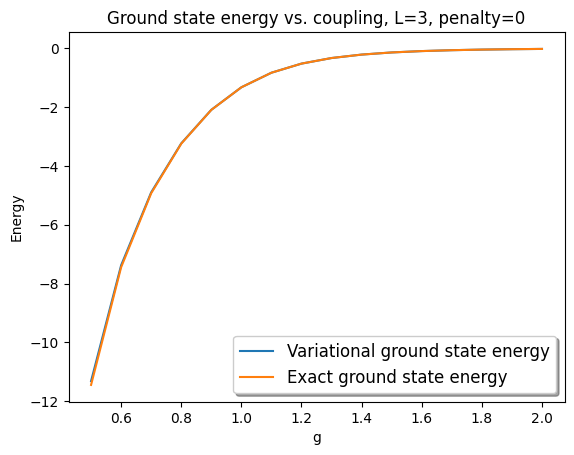

In [26]:
#Make plots
fig, ax = plt.subplots()

true_ground_state_energies = [ get_ground_state_energy(gi, L, boundary, penalty) for gi in gvals ]

plt.title(f"Ground state energy vs. coupling, L={L}, penalty={penalty}") 
plt.xlabel("g") 
plt.ylabel("Energy")

ax.plot( gvals, variational_ground_state_energies ,'-', label="Variational ground state energy")
ax.plot( gvals, true_ground_state_energies ,'-', label="Exact ground state energy")
legend = ax.legend(loc='best', shadow=True, fontsize='large')
plt.show()

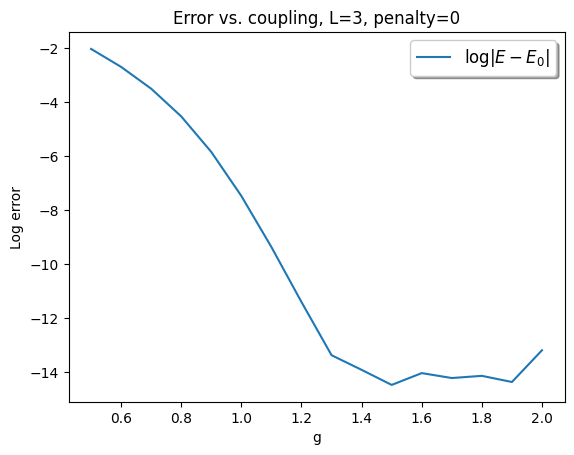

In [27]:
#Make plots
fig, ax = plt.subplots()

relative_error =  np.log( np.abs(  np.array(variational_ground_state_energies) - true_ground_state_energies ) ) 

plt.title(f"Error vs. coupling, L={L}, penalty={penalty}") 
plt.xlabel("g") 
plt.ylabel("Log error")

ax.plot( gvals, relative_error ,'-', label=r"$\log|E - E_0|$")
legend = ax.legend(loc='best', shadow=True, fontsize='large')
plt.show()

# Trotterized Ansatz

The ansatz in the previous section is difficult to implement on hardware, and besides it is costly to compute classically. A more realistic operator (and one that is easier to compute in the present context) involves trotterizing the operator:

$$ \exp( i \theta \sum_{p} \hat{Y}_p \prod_{q \in \partial p} \hat{P}_{0,q} ) \approx \prod_{p} \exp( i \theta  \hat{Y}_p \prod_{q \in \partial p} \hat{P}_{0,q} ) + \mathcal{O}(\theta^2) $$

While we have no a-priori reason to expect $\theta$ to be small, in practice it seems to be relatively small. On the other hand, we need not consider this to be an approximation to the previous ansatz, but rather as its own asatz with a different optimal parameter $\theta^*$.

One concern is that this ansatz breaks translation invariance by picking a preferred ordering for the lattice sites. We can restore partial translation invariance by instead breaking up the ansatz as

$$ | \psi(\theta) \rangle = \left[ \prod_{p \in E} \exp( i \theta  \hat{Y}_p \prod_{q \in \partial p} \hat{P}_{0,q} ) \right] \left[ \prod_{p \in O} \exp( i \theta  \hat{Y}_p \prod_{q \in \partial p} \hat{P}_{0,q} ) \right] $$

where $E$ and $O$ denote the even and odd sublattices. This ansatz now at least has translation invariance when moving by 2 sites. When the lattice has an even side length $L$, the even and odd sublattices are of equal size and are an equal footing when periodic boundary conditions are used. When the lattice side length $L$ is odd, the even and odd sublattices are of different sizes, and using a single variational parameter $\theta$ for both lattices might give poorer results. This will have to be investigated numerically.

When computing a single term in this product, we have

$$ \exp(i Y_p P) = \exp(i Y_p) P + (1 - P) $$

where $P = \prod_{q \in \partial p} \hat{P}_{0,q}$. Then the only matrix exponential we have to compute is the 2x2 $\exp(i\theta Y_p)$.

In [ ]:
'''
    Function that returns a 2^n x 2^n sparse matrix encoding the trotterized operator that enacts the ansatz described above.
'''
def Y_magnetic_ansatz_operator_trotterized(L, theta):
    # The 2x2 rotation matrix only needs to be computed once:
    RY = np.cos(theta)*Id + 1j*np.sin(theta)*Yop

    n = int(L*L)

    # Create a matrix to store the result
    result = eye(2**n, format='csr')

    # Loop over the lattice
    for p in range(n):
        # Find the nieghbors of the plaquette
        i, j = map_to_lattice(p, L)
        nl   = map_to_circuit((i - 1) % L, j, L)
        nd   = map_to_circuit(i, (j - 1) % L, L)
        nr   = map_to_circuit((i + 1) % L, j, L)
        nu   = map_to_circuit(i, (j + 1) % L, L)
        neighbors = [nl, nd, nr, nu]

        # Compute the projector P that acts on the neighbors
        op_dict = {}
        for q in neighbors:
            op_dict[q] = P0
        P = multi_qubit_gate(op_dict, L)

        # Efficiently compute exp(i Y P)
        trotter_step = one_qubit_gate( RY, p, L)@P + (eye(2**n, format='csr') - P)

        # Update the result
        result = trotter_step @ result

    return result

def Y_magnetic_ansatz_trotterized(L, theta):
    # Return the variational ansatz state vector resulting from the Y magnetic ansatz
    H = Y_magnetic_ansatz_operator_trotterized(L, theta)
    return H[:,0]

def Y_magnetic_ansatz_estimate_energy_trotterized(theta_array, g, L, boundary='periodic', penalty=0):
    # Compute the expectation value <psi| H | psi> of the variational state |psi> with respect to the system Hamiltonian H.
    theta = theta_array[0]
    trial_state = Y_magnetic_ansatz_trotterized(L, theta)
    H = make_ham(g, L, boundary=boundary, penalty=penalty)
    return np.real( np.conjugate(np.transpose(trial_state)) @ H @ trial_state )[0,0]

In [7]:
%%time
g = 1.
L = 3
boundary = 'periodic'
penalty = 0

def Y_magnetic_ansatz_cost_function_trotterized(theta_array):
    return Y_magnetic_ansatz_estimate_energy_trotterized(theta_array, g, L, boundary=boundary, penalty=penalty)

theta0 = [0.1]

result = minimize(Y_magnetic_ansatz_cost_function_trotterized, theta0, args=(), method='COBYLA', jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)

print( f"(Variational ground state energy) - (true ground state energy) = {result['fun'] - get_ground_state_energy(g, L, boundary=boundary, penalty=penalty)}" )
result

(Variational ground state energy) - (true ground state energy) = 0.0009851211466804788
CPU times: user 5.15 s, sys: 22.6 ms, total: 5.17 s
Wall time: 5.18 s


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.329546366873139
       x: [ 1.994e-01]
    nfev: 23
   maxcv: 0.0

## L = 3 Variational calculation

In [156]:
L = 3
gvals = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0])
boundary = 'periodic'
penalty = 0

def cost_function(theta_array):
    return Y_magnetic_ansatz_estimate_energy_trotterized(theta_array, g, L, boundary=boundary, penalty=penalty)

theta0 = [0.1]

variational_ground_state_energies = []

for i in range(len(gvals)):
    g = gvals[i]
    h = make_ham(g, L, boundary=boundary, penalty=penalty)
    result = minimize(cost_function, theta0, args=(), method='COBYLA', jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    variational_ground_state_energies.append( result['fun'] )
    print(f"Computation up to g={g} complete.", end='\r')

Computation up to g=2.0 complete.

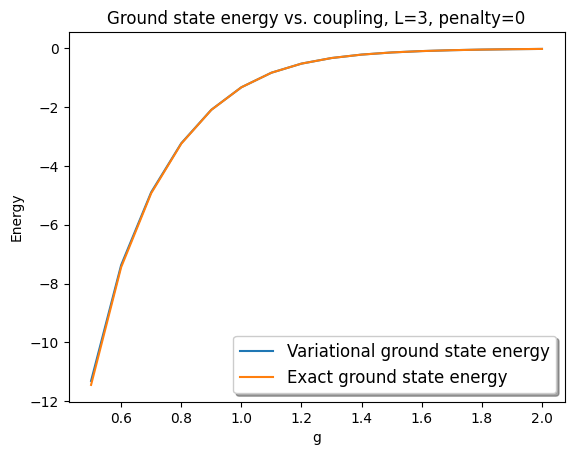

In [157]:
#Make plots
fig, ax = plt.subplots()

true_ground_state_energies = [ get_ground_state_energy(gi, L, boundary, penalty) for gi in gvals ]

plt.title(f"Ground state energy vs. coupling, L={L}, penalty={penalty}") 
plt.xlabel("g") 
plt.ylabel("Energy")

ax.plot( gvals, variational_ground_state_energies ,'-', label="Variational ground state energy")
ax.plot( gvals, true_ground_state_energies ,'-', label="Exact ground state energy")
legend = ax.legend(loc='best', shadow=True, fontsize='large')
plt.show()

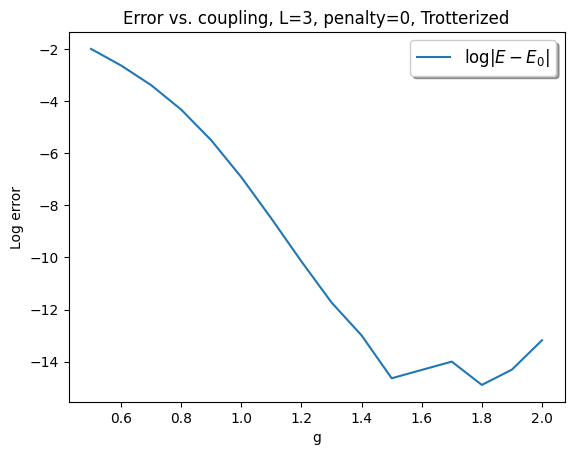

In [158]:
#Make plots
fig, ax = plt.subplots()

relative_error =  np.log( np.abs(  np.array(variational_ground_state_energies) - true_ground_state_energies ) ) 

plt.title(f"Error vs. coupling, L={L}, penalty={penalty}, Trotterized") 
plt.xlabel("g") 
plt.ylabel("Log error")

ax.plot( gvals, relative_error ,'-', label=r"$\log|E - E_0|$")
legend = ax.legend(loc='best', shadow=True, fontsize='large')
plt.show()

## L=4 Variational calculation

In [159]:
L = 4
gvals = np.array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5])
boundary = 'periodic'
penalty = 0

def cost_function(theta_array):
    return Y_magnetic_ansatz_estimate_energy_trotterized(theta_array, g, L, boundary=boundary, penalty=penalty)

theta0 = [0.1]

variational_ground_state_energies = []

for i in range(len(gvals)):
    g = gvals[i]
    h = make_ham(g, L, boundary=boundary, penalty=penalty)
    result = minimize(cost_function, theta0, args=(), method='COBYLA', jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    variational_ground_state_energies.append( result['fun'] )
    print(f"Computation up to g={g} complete.", end='\r')

Computation up to g=1.5 complete.

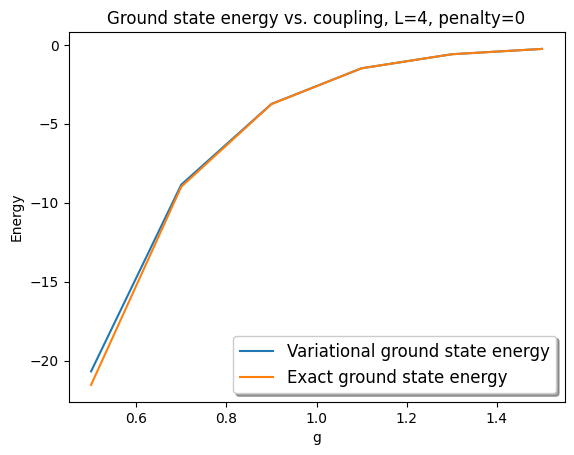

In [160]:
#Make plots
fig, ax = plt.subplots()

true_ground_state_energies = [ get_ground_state_energy(gi, L, boundary, penalty) for gi in gvals ]

plt.title(f"Ground state energy vs. coupling, L={L}, penalty={penalty}") 
plt.xlabel("g") 
plt.ylabel("Energy")

ax.plot( gvals, variational_ground_state_energies ,'-', label="Variational ground state energy")
ax.plot( gvals, true_ground_state_energies ,'-', label="Exact ground state energy")
legend = ax.legend(loc='best', shadow=True, fontsize='large')
plt.show()

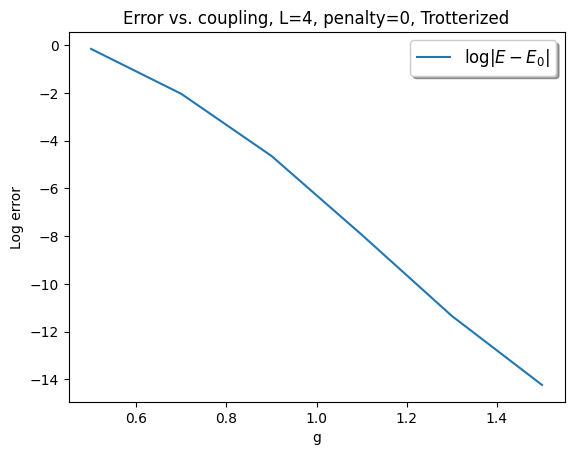

In [161]:
#Make plots
fig, ax = plt.subplots()

relative_error =  np.log( np.abs(  np.array(variational_ground_state_energies) - true_ground_state_energies ) ) 

plt.title(f"Error vs. coupling, L={L}, penalty={penalty}, Trotterized") 
plt.xlabel("g") 
plt.ylabel("Log error")

ax.plot( gvals, relative_error ,'-', label=r"$\log|E - E_0|$")
legend = ax.legend(loc='best', shadow=True, fontsize='large')
plt.show()

## L=5 Variational calculation

With my current calculational methods, this will take a *long*, *long* time